# Imports

In [20]:
import os
import shutil
import matplotlib.pyplot as plt
import torch
import random  
import numpy as np

Set the paths and import the label array

In [21]:
# Define the path to the folder containing the images and labels
data_folder = os.getcwd()+"/Square Images/"

# Load the labels from the NPY file
labels = torch.load(data_folder+'y_generated.pt')

# Get the list of image filenames
image_files = os.listdir(data_folder)
image_files = [f for f in image_files if f.endswith('.png')]

Plot the distribution of the generated data before removing training examples that are empty squares to rebalance the data. We save that plot in data directory because we will not be able to generate it after splitting in folders. We expect a lot of empty squares in the data.

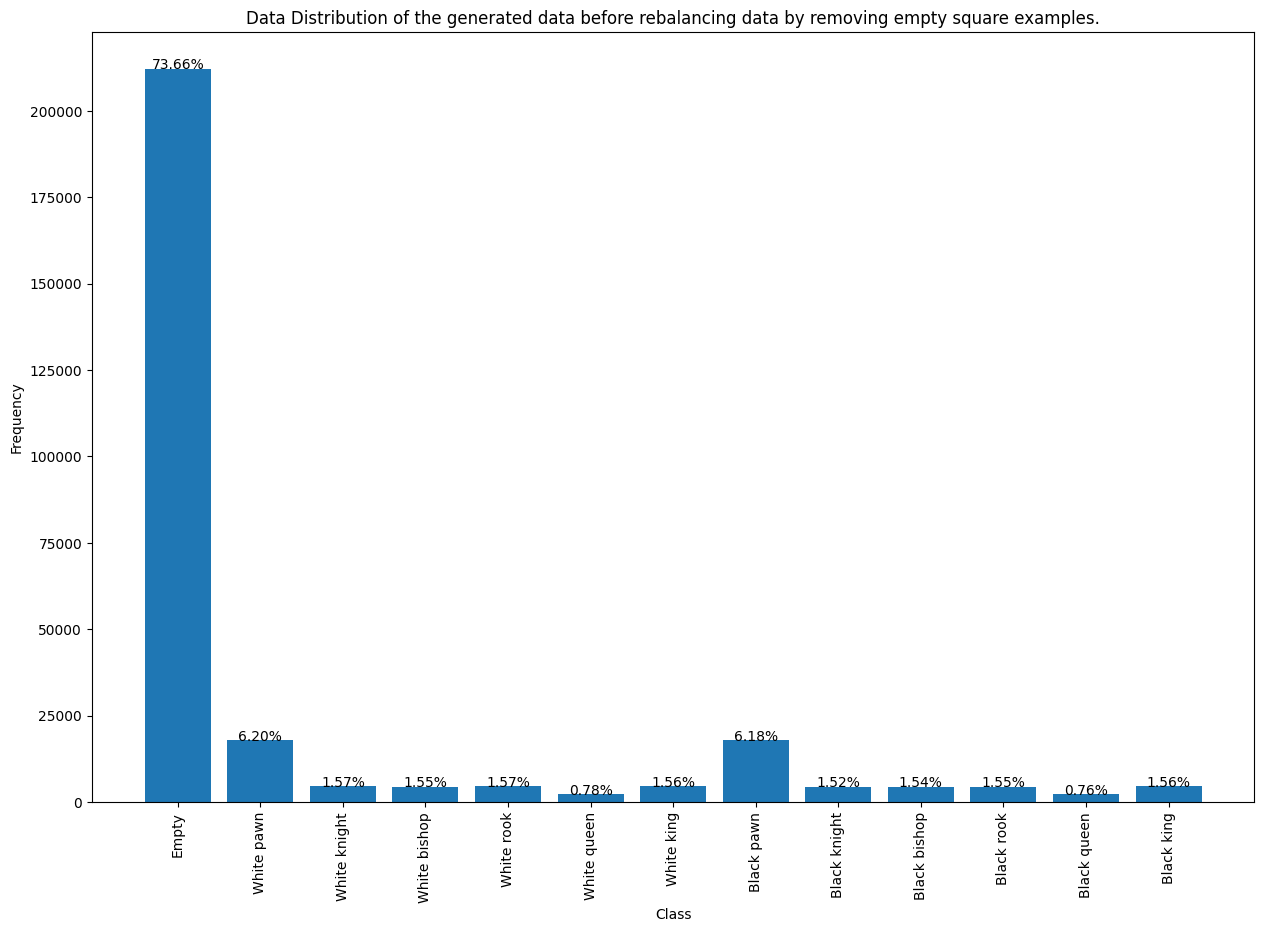

In [22]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a figure with two subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))

# plot the first histogram on the left subplot
hist, bins, _ = ax1.hist(labels, bins=range(14), align='left', rwidth=0.8)
ax1.set_xticks(list(class_names.keys()))
ax1.set_xticklabels(list(class_names.values()), rotation='vertical')
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution of the generated data before rebalancing data by removing empty square examples.')

# Store the count of each class in an array to define the losses later
samples_per_class_generated = hist

# add count number above each bar
for i in range(len(class_names)):
    ax1.text(i, (hist[i])+5, "{:.2f}%".format(int(hist[i]*100)/labels.shape[0]), ha='center')

# adjust the layout of the subplots
plt.subplots_adjust(wspace=0.5)

# save the plot
# Check file doesnt exist before saving
if not os.path.exists(data_folder+"/../data_distribution_generated_before_rebalancing.png"):
    plt.savefig(data_folder+"/../data_distribution_generated_before_rebalancing.png")

# show the plot
plt.show()

Based on the histogram, it is evident that empty squares make up the majority, comprising about 74% of the images. Moreover, and as expected, pawns have the highest proportion among the chess pieces (around 12% in total). Additionally, the proportion of white and black pieces is similar for each piece. For instance, the proportion of the white queen is 0.78%, while that of the black queen is 0.76%.

In this context, the imbalance in the data due to the abundance of empty squares may cause the model to have a bias towards identifying empty squares rather than chess pieces. To mitigate this issue, a pre-processing step is suggested, which involves removing a significant portion of training examples that correspond to empty squares. The objective is to provide a more balanced data set, where the number of training examples that are empty squares is equal to the number of training examples that correspond to pawns (black and white combined). This step helps to improve the focus of the model on recognizing chess pieces rather than empty squares, which may not contain any useful information for the classification task. Additionally, too many empty squares may hinder domain adaptation since empty squares are similar across both domains. Furthermore, since empty squares are easy to recognize, their over-representation may lead the model to overfit to empty squares rather than the task of identifying chess pieces. Finally, it is worth noting that other classes such as knight, king, etc. are kept unchanged since they are critical for the classification task.

In [23]:
# Tensor with the indices of the empty squares
empty_squares_indices = (labels == 0).nonzero().squeeze()

# Number of pawns in the dataset, add the number of white and black pawns
number_pawns = torch.where(labels == 1, 1, 0).sum() + torch.where(labels == 7, 1, 0).sum()

print("The number of pawns in the dataset is:", number_pawns)
print("The array of indices for empty squares is:")
print(empty_squares_indices[:100])
print("Total number of empty squares is:", empty_squares_indices.shape[0])

The number of pawns in the dataset is: tensor(35663)
The array of indices for empty squares is:
tensor([  1,   2,   3,   7,   8,   9,  10,  11,  14,  15,  16,  18,  19,  20,
         21,  23,  24,  25,  26,  27,  28,  29,  30,  32,  33,  34,  35,  37,
         38,  39,  40,  42,  44,  45,  46,  48,  50,  52,  53,  54,  55,  56,
         57,  58,  59,  61,  62,  63,  64,  65,  66,  68,  69,  70,  71,  72,
         73,  76,  77,  78,  79,  80,  81,  82,  83,  86,  88,  89,  90,  91,
         93,  94,  95,  96,  97,  98,  99, 100, 102, 104, 109, 110, 113, 115,
        116, 117, 118, 119, 120, 124, 125, 126, 127, 128, 130, 131, 133, 135,
        136, 137])
Total number of empty squares is: 212194


In [24]:
random_indices = random.sample(range(empty_squares_indices.shape[0]), number_pawns)
random_indices = torch.tensor(random_indices)

# Delete the random indices from the tensor of empty squares indices
indices_to_delete = torch.tensor([i for i in empty_squares_indices if i not in empty_squares_indices[random_indices]])


print("The array of the indices of empty squares to delete is:")
print(indices_to_delete[:100])
print("Number of selected empty squares to delete:", indices_to_delete.shape[0])

The array of the indices of empty squares to delete is:
tensor([  1,   2,   3,   7,   8,   9,  10,  11,  15,  16,  18,  19,  21,  24,
         25,  26,  27,  28,  29,  30,  32,  33,  34,  35,  37,  38,  39,  40,
         42,  44,  45,  46,  48,  50,  54,  57,  58,  59,  61,  62,  68,  69,
         70,  71,  72,  76,  77,  79,  80,  82,  83,  86,  88,  89,  90,  91,
         94,  95,  96,  97,  98, 100, 102, 104, 109, 110, 113, 115, 117, 119,
        120, 124, 125, 126, 127, 128, 131, 135, 136, 137, 139, 140, 143, 145,
        146, 147, 149, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 163,
        164, 165])
Number of selected empty squares to delete: 176531


Make a copy of the labels, without the ones corresponding to the empty squares we just deleted, to plot the new distribution and save it.

In [10]:
# Create copy of labels to evaluate the new distribution after
y_piece_generated = labels.clone()

# Use torch.index_select to select elements to keep
keep_indices = torch.tensor([i for i in range(y_piece_generated.shape[0]) if not i in indices_to_delete])
y_piece_generated = torch.index_select(y_piece_generated, dim=0, index=keep_indices)

We now plot this new class distribuition. We expect the number of empty squares to be dramatically smaller, with a proportion similar to the ones of pawns (again white and black pawns combined).

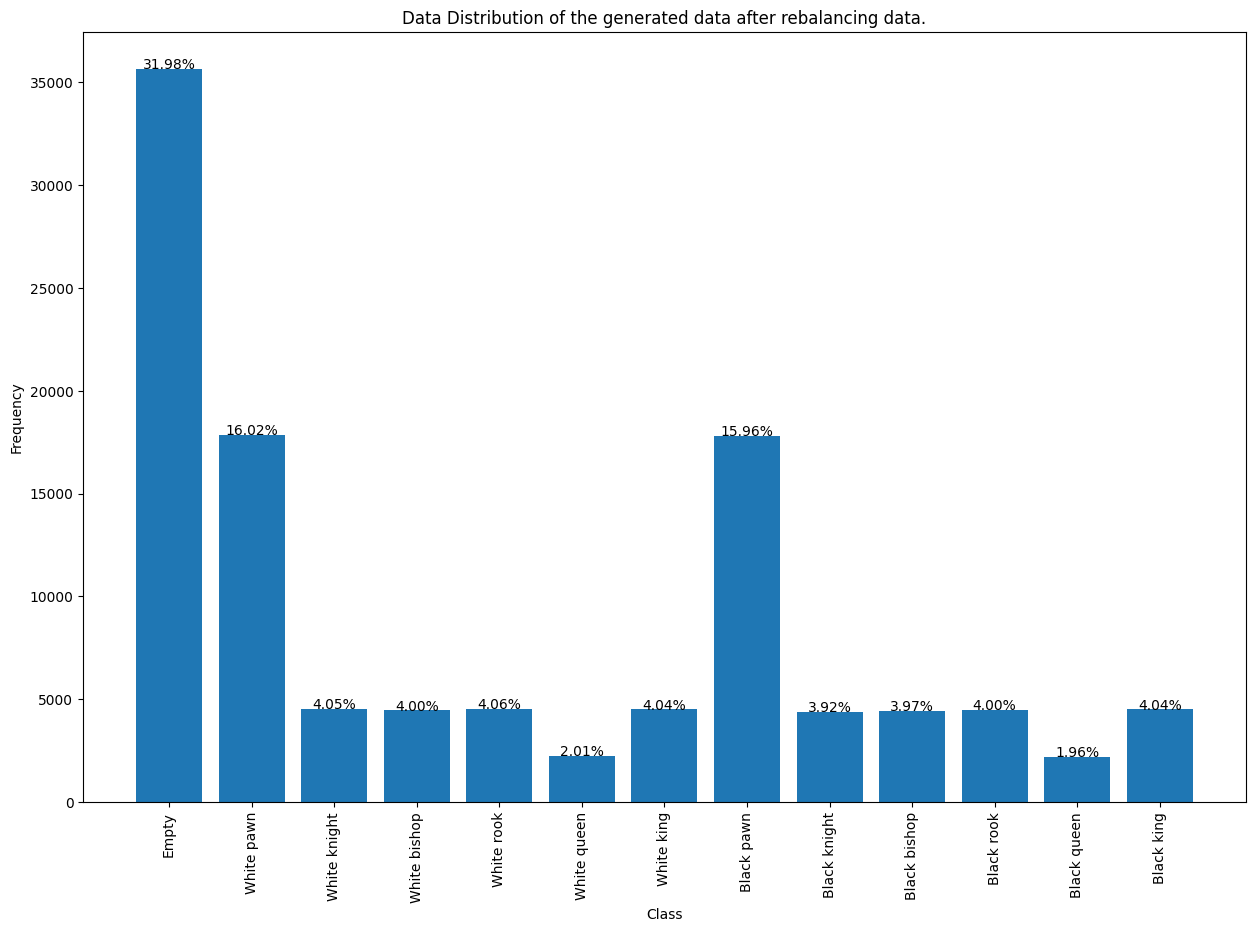

In [35]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a figure with two subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))

# plot the first histogram on the left subplot
hist, bins, _ = ax1.hist(y_piece_generated, bins=range(14), align='left', rwidth=0.8)
ax1.set_xticks(list(class_names.keys()))
ax1.set_xticklabels(list(class_names.values()), rotation='vertical')
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution of the generated data after rebalancing data.')

# Store the count of each class in an array to define the losses later
samples_per_class_generated = hist

# add count number above each bar
for i in range(len(class_names)):
    ax1.text(i, (hist[i])+5, "{:.2f}%".format(int(hist[i]*100)/y_piece_generated.shape[0]), ha='center')

# adjust the layout of the subplots
plt.subplots_adjust(wspace=0.5)

# save the plot
# Check file doesnt exist before saving
if not os.path.exists(data_folder+"/../data_distribution_generated_after_rebalancing.png"):
    plt.savefig(data_folder+"/../data_distribution_generated_after_rebalancing.png")

# show the plot
plt.show()

Remove empty squares from image dataset:

In [31]:
# Remove empty squares from data set:
count = 0
count2 = 0

for img in image_files:
    count+=1
    if int(img[3:9]) in indices_to_delete:
        count2+=1
        os.remove(data_folder+img)


print("Number of images removed:", count2)
print("Number of images:", count)

Number of images removed: 176531
Number of images: 288064


Now we retake the filenames of the files that were not deleted and loop over them to split into test, train and validation.

In [33]:
# Define the path to the folder containing the images and labels
data_folder = os.getcwd()+"/Square Images/"

# Load the labels from the NPY file
labels = torch.load(data_folder+'y_piece_generated.pt')

# Get the list of image filenames
image_files = os.listdir(data_folder)
image_files = [f for f in image_files if f.endswith('.png')]

In [34]:
# Shuffle the image files and their corresponding labels in the same order
indices = np.random.permutation(len(image_files))
image_files = [image_files[i] for i in indices]
labels = labels[indices]

# Delete some training examples 

# Define the ratios of the training, validation, and testing sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the sizes of the training, validation, and testing sets
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = num_images - num_train - num_val

# Define the paths to the subfolders
train_folder = os.path.join(data_folder, 'Training')
val_folder = os.path.join(data_folder, 'Validation')
test_folder = os.path.join(data_folder, 'Testing')

# Create the subfolders if they don't exist
for folder in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Move the images and their labels to the subfolders
for i, image_file in enumerate(image_files):
    if i < num_train:
        folder = train_folder
    elif i < num_train + num_val:
        folder = val_folder
    else:
        folder = test_folder

    src_file = os.path.join(data_folder, image_file)
    dst_file = os.path.join(folder, image_file)
    shutil.copy(src_file, dst_file)
    os.remove(src_file)